In [8]:
#Basic library imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd  
from collections import Counter
import seaborn as sn
from __future__ import division
import sklearn
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
import geoplotlib
from geoplotlib.utils import BoundingBox, DataAccessObject
from geoplotlib.colors import ColorMap

In [9]:
#We use pandas to read and store the data from the .csv file
crime_data=pd.read_csv("SFPD_Incidents_-_from_1_January_2003.csv")

#Week 5, Part 2: Clustering (DSFS Chapter 19)

***Exercise:* K-means**

* **Visualize the prostitution data (e.g. by plotting it on a map)**

In [10]:
#Drop the outlier
crime_data = crime_data[crime_data.Y != 90.]

In [11]:
prostitution_data = crime_data[crime_data.Category=='PROSTITUTION']

In [27]:
geo_data_for_plotting = {"lat": list(crime_data.Y), "lon": list(crime_data.X)}
geo_data_prost = {"lat": list(prostitution_data.Y), "lon": list(prostitution_data.X)}

#Set north, south, west, east points
n = max(geo_data_for_plotting["lat"])-0.022
s = min(geo_data_for_plotting["lat"])+0.022
w = min(geo_data_for_plotting["lon"])+0.022
e = max(geo_data_for_plotting["lon"])-0.022
bbox = BoundingBox(north = n, south = s,west = w,east = e)

geoplotlib.dot(geo_data_prost, point_size=3)
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

* **Train models of *K=2,…,10* on the prostitution data.**

In [13]:
prostitution_data.drop(['Category','Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'Location','Date'\
                       ,'IncidntNum', 'Time','PdId'], axis=1, inplace=True)

C:\Users\Stef\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
pdata = prostitution_data.values
krange = range(2,11)

#fit the model for k in 2,...,10
k_means_various = [KMeans(n_clusters=k).fit(pdata) for k in krange]

#get the centroid of every model
centroids = [k.cluster_centers_ for k in k_means_various]

#get the labels of every model
klabels = [k.labels_ for k in k_means_various]

**Centroids to .csv**

In [15]:
i=2
for k_group in centroids:
    df_centroids = pd.DataFrame()
    lat=[]
    lon=[]
    for centroid in k_group:
        lat.append(centroid[1])
        lon.append(centroid[0])
    df_centroids['lat']=lat
    df_centroids['lon']=lon
    file_name = 'centroid'+str(i)+'.csv'
    df_centroids.to_csv(file_name, sep=',', index = False)
    i+=1 

**Labels and points to .csv**

In [16]:
i=2
for klabel_group in klabels:
    geo_data = pd.DataFrame()
    geo_data['lat'] = prostitution_data.Y
    geo_data['lon'] = prostitution_data.X
    geo_data['label'] = klabel_group
    file_name = 'labeled_data'+str(i)+'.csv'
    geo_data.to_csv(file_name, sep=',', index = False)
    i+=1

* **Explore how the total squared error changes as a function of K and identify what you think is the right number of clusers based on the knee-point in the squared error plot.**

In [17]:
from scipy.spatial.distance import cdist, pdist

#Eucledian distance from each point to each cluster center
k_euclid = [cdist(pdata,cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

#Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

#total sum of squares
tss = sum(pdist(pdata)**2)/pdata.shape[0]

#between clusters sum of squares
bss = wcss-tss

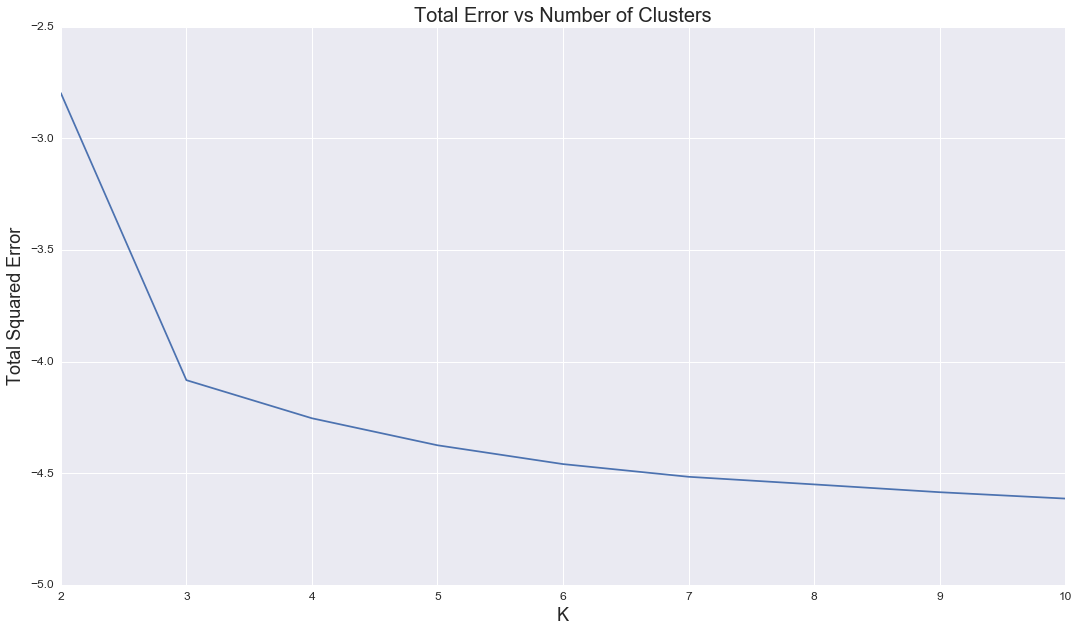

In [18]:
%matplotlib inline

plt.figure(figsize=(18,10))
plt.plot(krange, bss)
plt.xticks(krange, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("K", fontsize=18)
plt.ylabel("Total Squared Error", fontsize=18)
plt.title("Total Error vs Number of Clusters", fontsize=20)

As seen from the plot above, 3 seems to be the right number of clusters as it minimises the error before the complexity starts to grow.

* **And by the way: The fit only gets better when we add more means - why not keep adding more of them: Explain in your own words why it makes sense to stop around a knee-point.**

After the knee point the complexity of the model increases while the reduction of the errors is linearly small. Thus, it make sense to stop at the knee point and choose the K that minimizes the error before increasing model complexity and avoid overfitting. Increasing the number of clusters infinitely will result to every point being its own cluster, something non intuituitive and sure to overfit.